In [1]:
import random
import datetime
from os import listdir

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from math import radians, degrees, sin, cos, asin, acos, sqrt

from sklearn import metrics

import seaborn as sns

import itertools


## Read in data

In [3]:
path = 'cabspottingdata/'

files = [file_name for file_name in listdir(path) if file_name.endswith('.txt')]
print(f'All files are {len(files)}')

All files are 537


In [4]:
df=pd.DataFrame()
for file in files:
    taxi_df=pd.read_csv(path+file, sep=' ', header=None)
    taxi_df.columns= ['latitude', 'longitude', 'occupancy', 'timestamp']
    taxi_df["taxi"]=file.split(".txt")[0]
    df=df.append(taxi_df)

In [6]:
df.shape

(11220058, 5)

Check if Taxi id number equal to file number

In [7]:
len(set(df["taxi"]))==len(files)

True

In [114]:
df.head()

latitude  longitude  occupancy   timestamp        taxi
0  37.75153 -122.39447          0  1211033530  new_abboip
1  37.75149 -122.39447          0  1211033614  new_abboip
2  37.75149 -122.39447          0  1211033674  new_abboip
3  37.75149 -122.39446          0  1211033735  new_abboip
4  37.75144 -122.39449          0  1211035303  new_abboip

## Preprocess

In [8]:
df=df.sort_values(by=['taxi','timestamp'])

In [9]:
for metric in ["latitude","longitude","timestamp","occupancy"]:
    df["pre_"+metric]=df.groupby("taxi")[metric].shift(1)

In [130]:
df.head()

latitude  longitude  occupancy   timestamp        taxi  pre_latitude  \
0  37.75153 -122.39447          0  1211033530  new_abboip           NaN   
1  37.75149 -122.39447          0  1211033614  new_abboip      37.75153   
2  37.75149 -122.39447          0  1211033674  new_abboip      37.75149   
3  37.75149 -122.39446          0  1211033735  new_abboip      37.75149   
4  37.75144 -122.39449          0  1211035303  new_abboip      37.75149   

   pre_longitude  pre_timestamp  pre_occupancy  
0            NaN            NaN            NaN  
1     -122.39447   1.211034e+09            0.0  
2     -122.39447   1.211034e+09            0.0  
3     -122.39447   1.211034e+09            0.0  
4     -122.39446   1.211034e+09            0.0

In [10]:
df.isnull().sum()

latitude           0
longitude          0
occupancy          0
timestamp          0
taxi               0
pre_latitude     537
pre_longitude    537
pre_timestamp    537
pre_occupancy    537
dtype: int64

Calculate the distance of consectutive movement in the records

In [31]:
# Refer to https://www.geeksforgeeks.org/program-distance-two-points-earth/##

def distance(lat1, lat2, lon1, lon2):

        lon1 = radians(lon1)
        lon2 = radians(lon2)
        lat1 = radians(lat1)
        lat2 = radians(lat2)
        
        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    
        c = 2 * asin(sqrt(a))
        
        # Radius of earth in kilometers. Use 3956 for miles
        #r = 6371
        r=3956
        
        # calculate the result
        return(c * r)


In [12]:
df["distance"]=df.apply(lambda row:distance(row["latitude"],row["pre_latitude"],row["longitude"],row["pre_longitude"]),axis=1)

In [13]:
df["duration"]=df["timestamp"]-df["pre_timestamp"]
df["state_change"]=df["occupancy"]-df["pre_occupancy"]
df["latitude_change"]=df["latitude"]-df["pre_latitude"]
df["longitude_change"]=df["longitude"]-df["pre_longitude"]

In [17]:
df=df.drop(["pre_timestamp","pre_occupancy","pre_latitude","pre_longitude"],axis=1)

In [18]:
df.head()

latitude  longitude  occupancy   timestamp        taxi  distance  duration  \
0  37.75153 -122.39447          0  1211033530  new_abboip       NaN       NaN   
1  37.75149 -122.39447          0  1211033614  new_abboip  0.002762      84.0   
2  37.75149 -122.39447          0  1211033674  new_abboip  0.000000      60.0   
3  37.75149 -122.39446          0  1211033735  new_abboip  0.000546      61.0   
4  37.75144 -122.39449          0  1211035303  new_abboip  0.003821    1568.0   

   state_change  latitude_change  longitude_change  
0           NaN              NaN               NaN  
1           0.0         -0.00004           0.00000  
2           0.0          0.00000           0.00000  
3           0.0          0.00000           0.00001  
4           0.0         -0.00005          -0.00003

In [19]:
df.isnull().sum()

latitude              0
longitude             0
occupancy             0
timestamp             0
taxi                  0
distance            537
duration            537
state_change        537
latitude_change     537
longitude_change    537
dtype: int64

In [20]:
df=df.fillna(0)

In [21]:
df.to_csv("master_data.csv",index=False)

In [17]:
# df=pd.read_csv("master_data.csv")
# df=df.sort_values(by=['taxi','timestamp'])

## EDA

In [24]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

df.describe()

latitude      longitude      occupancy        timestamp  \
count 11220058.00000 11220058.00000 11220058.00000   11220058.00000   
mean        37.76360     -122.41243        0.44722 1212036378.24358   
std          0.05386        0.03578        0.49721     588568.31508   
min         32.86970     -127.08143        0.00000 1211018404.00000   
25%         37.75513     -122.42525        0.00000 1211522838.00000   
50%         37.78106     -122.41106        0.00000 1212043209.00000   
75%         37.79045     -122.40027        1.00000 1212548807.00000   
max         50.30546     -115.56218        1.00000 1213089934.00000   

            distance       duration   state_change  latitude_change  \
count 11220058.00000 11220058.00000 11220058.00000   11220058.00000   
mean         0.25589       91.15745        0.00000         -0.00000   
std          1.40452     1567.07180        0.28756          0.01941   
min          0.00000        0.00000       -1.00000        -12.69148   
25%          0.02014       52.00000        0.00000         -0.00079   
50%          0.14508       60.00000        0.00000          0.00000   
75%          0.28575       62.00000        0.00000          0.00086   
max        876.50302  1488682.00000        1.00000         12.67098   

       longitude_change  
count    11220058.00000  
mean            0.00000  
std             0.00898  
min            -6.84999  
25%            -0.00111  
50%             0.00000  
75%             0.00112  
max             6.84992

Check the movement range of each step in the records. On average, each movement has change in latitude and/or longitude of 0.0025. Will refer to this typical movement scale later on.

In [51]:
latitude_change_abs_mean=abs(df["latitude_change"]).mean()
print(latitude_change_abs_mean)

0.002592008561809572


In [52]:
longitude_change_abs_mean=abs(df["longitude_change"]).mean()
print(longitude_change_abs_mean)

0.00248415719063128


## Q1: Co2 emission reduction potential

To calculate the potential for a yearly reduction in CO2 emissions, caused by the taxi cabs roaming without passengers. In your calculation, please assume that the taxicab fleet is changing at the rate of 15% per month (from combustion engine-powered vehicles to electric vehicles). Assume also that the average passenger vehicle emits about 404 grams of CO2 per mile.

calcuate the total roaming distance without a passenger for the month in data

In [748]:
non_occupancy_distance=sum(df.loc[df["occupancy"]==0]["distance"])

In [750]:
print(non_occupancy_distance)

1263482.9152560702


Reduction rate of driving distance without passenger in one year, along with 15% per month's changing rate from engine-powred vehicles to electric vehicles. 

In [752]:
reduction_rate=1-(1-0.85**12)/(1-0.85)/12

In [753]:
print(reduction_rate)

0.5234676428534291


Annual reduction potential in CO2 emissions

In [755]:
reduction_potential=non_occupancy_distance*404*12*reduction_rate

In [756]:
print(reduction_potential)

3206430468.8112993


## Q2: Predict the next place a passenger will hail a cab

This task will be finised in two steps. 

First step: contruct a classification model to predict that given a next destination, if the un-loaded taxi will pick up a passenger.

Second step: perform simultion on possible next desitnations of an un-loaded taxi, and make preditions by using the ML model obtained in step 1. Based on the predictions on simulated destinations, ### recommand taxi the next destination with higher possibility to pick up a passenger 

### Classification model buiding 

Get the very initial drop off time and very last pick up time of each taxi

In [130]:
first_drop_off=df.loc[df["state_change"]==-1].groupby("taxi")["timestamp"].min().reset_index().rename(columns={"timestamp":"first_drop_off_timestamp"})
last_pick_up=df.loc[df["state_change"]==1].groupby("taxi")["timestamp"].max().reset_index().rename(columns={"timestamp":"last_pick_up_timestamp"})

In [131]:
df=df.merge(first_drop_off,on="taxi",how="left").merge(last_pick_up,on="taxi",how="left")

Keep complete sessions of each taxi. Complete session means a session starts from a passenger drop off to another passenger pick up

In [132]:
truncated_df=df.loc[(df["timestamp"]>=df["first_drop_off_timestamp"]) & (df["timestamp"]<=df["last_pick_up_timestamp"])]

Construct all "drop-off -> pick-up" sessions

In [133]:
truncated_df=truncated_df.loc[~((truncated_df["occupancy"]==1) & (truncated_df["state_change"]==0))]

In [134]:
truncated_df.loc[truncated_df["state_change"]==-1,"duration"]=0
truncated_df.loc[truncated_df["state_change"]==-1,"distance"]=0

Construct drop-off->pick-up sessions for each taxies and assign session id

In [135]:
pick_up_df=truncated_df.loc[truncated_df["state_change"]==1][["taxi","timestamp"]].sort_values(by=["taxi","timestamp"])
pick_up_df["session_id"]=pick_up_df.reset_index().index

truncated_df=truncated_df.merge(pick_up_df,on=["taxi","timestamp"],how="left")
truncated_df["session_id"]=truncated_df["session_id"].bfill()
truncated_df["session_id"]=truncated_df["session_id"].astype(int)

Get the accumulated duration and distance since the drop off in each session

In [137]:
truncated_df["duration_cumsum"]=truncated_df.groupby(["session_id"])["duration"].cumsum()
truncated_df["distance_cumsum"]=truncated_df.groupby(["session_id"])["distance"].cumsum()

Get the total duration and total roaming distance for 95% of "drop-off -> pick-up" sessions. The portion over 95% will be considered as outlier and I will remove them

In [138]:
duration_threshold=np.percentile([i for i in truncated_df.loc[truncated_df["state_change"]==1]["duration_cumsum"]], 95)
print(duration_threshold)

5183.0


In [139]:
distance_threshold=np.percentile([i for i in truncated_df.loc[truncated_df["state_change"]==1]["distance_cumsum"]], 95)
print(distance_threshold)

13.385964233103099


Check the distribution of session time (in unit of second) and session length (in unit of miles)

<AxesSubplot:>

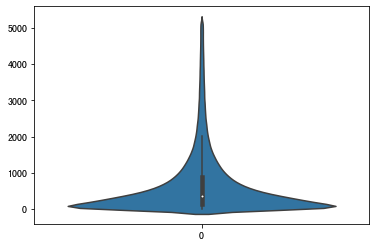

In [16]:
sns.violinplot([i for i in truncated_df.loc[truncated_df["state_change"]==1]["duration_cumsum"] if i<=duration_threshold])

<AxesSubplot:>

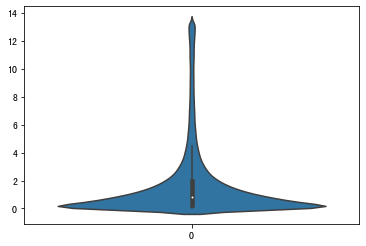

In [17]:
sns.violinplot([i for i in truncated_df.loc[truncated_df["state_change"]==1]["distance_cumsum"] if i<=distance_threshold])

Truncate sessions by the above threshold values

In [140]:
truncated_df=truncated_df.loc[(truncated_df["duration_cumsum"]<=duration_threshold) & (truncated_df["distance_cumsum"]<=distance_threshold)]

In [141]:
truncated_df.shape

(5551718, 15)

In [20]:
truncated_df.loc[truncated_df["state_change"]==1][["duration_cumsum"]].describe()

duration_cumsum
count    426508.000000
mean        639.020466
std         816.146042
min           1.000000
25%         130.000000
50%         352.000000
75%         813.000000
max        5183.000000

In [142]:
truncated_df.head()

latitude  longitude  occupancy   timestamp        taxi  distance  duration  \
0  37.75580 -122.41441          0  1211036160  new_abboip  0.000000       0.0   
1  37.76172 -122.41496          0  1211036230  new_abboip  0.409849      70.0   
2  37.76523 -122.41529          0  1211036280  new_abboip  0.243017      50.0   
3  37.76511 -122.41935          0  1211036344  new_abboip  0.221758      64.0   
4  37.76342 -122.41992          0  1211036401  new_abboip  0.120763      57.0   

   state_change  latitude_change  longitude_change  first_drop_off_timestamp  \
0          -1.0          0.00028          -0.00003                1211036160   
1           0.0          0.00592          -0.00055                1211036160   
2           0.0          0.00351          -0.00033                1211036160   
3           0.0         -0.00012          -0.00406                1211036160   
4           0.0         -0.00169          -0.00057                1211036160   

   last_pick_up_timestamp  session_id  duration_cumsum  distance_cumsum  
0              1213083415           0              0.0         0.000000  
1              1213083415           0             70.0         0.409849  
2              1213083415           0            120.0         0.652866  
3              1213083415           0            184.0         0.874624  
4              1213083415           0            241.0         0.995387

In [143]:
#truncated_df.to_csv("truncated_df.csv",index=False)
#truncated_df=pd.read_csv("truncated_df.csv")


The truncated_df data is too big for the following processing. Due to the limited time on this assignment, will perform data sampling.

Sample 20000 (or some other number) sessions from all 463511 sessions. The sampled sessions may come from different taxies. Would like to increase sample size for a better model performance if there is capacity.

In [113]:
session_list=list(truncated_df.session_id.unique())

In [206]:
len(session_list)

463511

In [207]:
random.seed(0)
sampled_session=random.sample(session_list,20000)

In [336]:
## For the purpose of continuously adding sample data
# old_master_df_file_name="master_df_40000.csv"
# new_master_df_file_name="master_df_60000.csv"
# master_df_last=pd.read_csv(old_master_df_file_name)

# len(set(master_df_last.session_id))
# sampled_session=random.sample(set(session_list)-set(master_df_last.session_id),20000)

In [339]:
sampled_session=random.sample(set(session_list),20000)

In [340]:
len(sampled_session)

20000

In [341]:
sampled_truncated_df=truncated_df.loc[truncated_df["session_id"].isin(sampled_session)]

Start generating additional features

Get weekday, hour, minute from unix timestamp

In [342]:
import multiprocessing as mp

import datetime

def generate_weekday(timestamp):
    return datetime.datetime.fromtimestamp(timestamp).weekday()

def generate_hour(timestamp):
    return datetime.datetime.fromtimestamp(timestamp).hour

def generate_minute(timestamp):
    return datetime.datetime.fromtimestamp(timestamp).minute

with mp.Pool(mp.cpu_count()) as pool:
    sampled_truncated_df['weekday'] = pool.map(generate_weekday, sampled_truncated_df['timestamp'])
    sampled_truncated_df['hour'] = pool.map(generate_hour, sampled_truncated_df['timestamp'])
    sampled_truncated_df['minute'] = pool.map(generate_minute, sampled_truncated_df['timestamp'])

/home/vastar/anaconda3/envs/ktrain/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/vastar/anaconda3/envs/ktrain/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/vastar/anaconda3/envs/ktrain/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

Get speed property

In [343]:
sampled_truncated_df["speed"]=sampled_truncated_df["distance"]/sampled_truncated_df["duration"]
sampled_truncated_df=sampled_truncated_df.fillna(0)

/home/vastar/anaconda3/envs/ktrain/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [344]:
sampled_truncated_df["index"]=np.arange(sampled_truncated_df.shape[0])
sampled_truncated_df=sampled_truncated_df.reset_index()

Construct features based on road information. I will look at 
1) Other taxi number in the nearby region of the taxi under track in the past given time period (1 minute)
2) Occupancy ratio of all taxies in 1)
3) All taxi numbers in the past given period (1 minute)
4) Occupancy ratio of all taxies in 3)

These collective information will be proved to be very important for the prediction model

In [345]:
delta_latitude=0.0025*4
delta_longitude=0.0025*4
delta_timestamp=60*1

def get_road_info(i):
    latitude,longitude,timestamp=sampled_truncated_df.loc[i,["latitude","longitude","timestamp"]]

    all_df=df.loc[(df["timestamp"]>=(timestamp-delta_timestamp)) & (df["timestamp"]<=timestamp)]
    taxi_cnt=len(set(all_df["taxi"]))
    taxi_occupancy_ratio=len(set(all_df.loc[all_df["occupancy"]==1]["taxi"]))/taxi_cnt

    surround_df=all_df.loc[(df["longitude"]<=(longitude+delta_longitude)) & (df["longitude"]>=(longitude-delta_longitude)) \
        & (df["latitude"]<=(latitude+delta_latitude)) & (df["latitude"]>=(latitude-delta_latitude)) \
        ]

    surround_taxi_cnt=len(set(surround_df["taxi"]))
    surround_taxi_occupancy_ratio=len(set(surround_df.loc[surround_df["occupancy"]==1]["taxi"]))/surround_taxi_cnt

    return i,surround_taxi_cnt,surround_taxi_occupancy_ratio,taxi_cnt,taxi_occupancy_ratio

In [346]:

with mp.Pool(mp.cpu_count()) as pool:
    road_info=pool.map(get_road_info, range(sampled_truncated_df.shape[0]))


In [347]:
road_info_df=pd.DataFrame(road_info)
road_info_df.columns=["index","surround_taxi_cnt","surround_taxi_occupancy_ratio","taxi_cnt","taxi_occupancy_ratio"]

In [348]:
road_info_df.head()

index  surround_taxi_cnt  surround_taxi_occupancy_ratio  taxi_cnt  \
0      0                  8                       0.250000       367   
1      1                  9                       0.222222       356   
2      2                  9                       0.333333       366   
3      3                  6                       0.166667       358   
4      4                  6                       0.500000       371   

   taxi_occupancy_ratio  
0              0.760218  
1              0.741573  
2              0.751366  
3              0.743017  
4              0.746631

In [349]:
sampled_truncated_df=sampled_truncated_df.merge(road_info_df,on="index",how="left")

In [350]:
sampled_truncated_df.head()

level_0  latitude  longitude  occupancy   timestamp        taxi  distance  \
0      461  37.74246 -122.40318          0  1211089247  new_abboip  0.000000   
1      462  37.74249 -122.40329          0  1211089308  new_abboip  0.006353   
2      463  37.74521 -122.40403          0  1211089367  new_abboip  0.192100   
3      464  37.74842 -122.40388          0  1211089430  new_abboip  0.221786   
4      465  37.75290 -122.40702          0  1211089476  new_abboip  0.353646   

   duration  state_change  latitude_change  ...  distance_cumsum  weekday  \
0       0.0          -1.0          0.00000  ...         0.000000        6   
1      61.0           0.0          0.00003  ...         0.006353        6   
2      59.0           0.0          0.00272  ...         0.198453        6   
3      63.0           0.0          0.00321  ...         0.420239        6   
4      46.0           0.0          0.00448  ...         0.773886        6   

   hour  minute     speed  index  surround_taxi_cnt  \
0    14      40  0.000000      0                  8   
1    14      41  0.000104      1                  9   
2    14      42  0.003256      2                  9   
3    14      43  0.003520      3                  6   
4    14      44  0.007688      4                  6   

   surround_taxi_occupancy_ratio  taxi_cnt  taxi_occupancy_ratio  
0                       0.250000       367              0.760218  
1                       0.222222       356              0.741573  
2                       0.333333       366              0.751366  
3                       0.166667       358              0.743017  
4                       0.500000       371              0.746631  

[5 rows x 25 columns]

Also get the direct distance from the very beginning of each session

In [351]:
session_start_point=sampled_truncated_df.loc[sampled_truncated_df["state_change"]==-1][["session_id","latitude","longitude"]]
session_start_point.columns=["session_id","start_latitude","start_longitude"]
sampled_truncated_df=sampled_truncated_df.merge(session_start_point,on="session_id",how="left")
sampled_truncated_df["direct_distance"]=sampled_truncated_df.apply(lambda row:distance(row["latitude"],row["start_latitude"],row["longitude"],row["start_longitude"]),axis=1)

In [352]:
sampled_truncated_df.head(60)

level_0  latitude  longitude  occupancy   timestamp        taxi  distance  \
0       461  37.74246 -122.40318          0  1211089247  new_abboip  0.000000   
1       462  37.74249 -122.40329          0  1211089308  new_abboip  0.006353   
2       463  37.74521 -122.40403          0  1211089367  new_abboip  0.192100   
3       464  37.74842 -122.40388          0  1211089430  new_abboip  0.221786   
4       465  37.75290 -122.40702          0  1211089476  new_abboip  0.353646   
5       466  37.75287 -122.40832          1  1211089517  new_abboip  0.070999   
6       936  37.79059 -122.40591          0  1211231743  new_abboip  0.000000   
7       937  37.79063 -122.40435          0  1211231801  new_abboip  0.085164   
8       938  37.79172 -122.40479          0  1211231861  new_abboip  0.078996   
9       939  37.79115 -122.40887          0  1211231922  new_abboip  0.226068   
10      940  37.79059 -122.40882          0  1211231982  new_abboip  0.038761   
11      941  37.78991 -122.40864          0  1211232044  new_abboip  0.047967   
12      942  37.78777 -122.40859          0  1211232103  new_abboip  0.147782   
13      943  37.78746 -122.40843          0  1211232170  new_abboip  0.023116   
14      944  37.78684 -122.41225          0  1211232223  new_abboip  0.212792   
15      945  37.78625 -122.41639          0  1211232283  new_abboip  0.229548   
16      946  37.78729 -122.42004          0  1211232336  new_abboip  0.211716   
17      947  37.78758 -122.42152          0  1211232396  new_abboip  0.083203   
18      948  37.78736 -122.42327          0  1211232467  new_abboip  0.096691   
19      949  37.78718 -122.42493          0  1211232517  new_abboip  0.091428   
20      950  37.78211 -122.42400          0  1211232593  new_abboip  0.353719   
21      951  37.77980 -122.42360          0  1211232610  new_abboip  0.160981   
22      952  37.77885 -122.42247          0  1211232662  new_abboip  0.090029   
23      953  37.77877 -122.42234          1  1211232765  new_abboip  0.008991   
24      965  37.78950 -122.39038          0  1211234033  new_abboip  0.000000   
25      966  37.78936 -122.39048          0  1211234060  new_abboip  0.011100   
26      967  37.78956 -122.39029          0  1211234122  new_abboip  0.017268   
27      968  37.78912 -122.38897          0  1211234186  new_abboip  0.078170   
28      969  37.79326 -122.39175          0  1211234242  new_abboip  0.323600   
29      970  37.79595 -122.39455          0  1211234307  new_abboip  0.240488   
30      971  37.79542 -122.39468          0  1211234362  new_abboip  0.037275   
31      972  37.79342 -122.39304          0  1211234423  new_abboip  0.164546   
32      973  37.79385 -122.39568          0  1211234483  new_abboip  0.147069   
33      974  37.79356 -122.39598          0  1211234545  new_abboip  0.025862   
34      975  37.79078 -122.39916          0  1211234605  new_abboip  0.258743   
35      976  37.79091 -122.39941          1  1211234636  new_abboip  0.016329   
36     1022  37.75726 -122.43687          0  1211240143  new_abboip  0.000000   
37     1023  37.75448 -122.43667          0  1211240215  new_abboip  0.192256   
38     1024  37.75114 -122.43634          0  1211240264  new_abboip  0.231314   
39     1025  37.74966 -122.43466          0  1211240301  new_abboip  0.137310   
40     1026  37.75009 -122.42777          0  1211240383  new_abboip  0.377319   
41     1027  37.74875 -122.42494          0  1211240453  new_abboip  0.180084   
42     1028  37.74814 -122.41681          0  1211240568  new_abboip  0.445847   
43     1029  37.74828 -122.41252          0  1211240628  new_abboip  0.234410   
44     1030  37.74906 -122.40520          0  1211240694  new_abboip  0.403243   
45     1031  37.74959 -122.39901          0  1211240744  new_abboip  0.339911   
46     1032  37.74980 -122.39514          0  1211240804  new_abboip  0.211774   
47     1033  37.75162 -122.39521          0  1211240864  new_abboip  0.125720   
48     1034  37.75140 -122.39512   

In [353]:
sampled_truncated_df.columns

Index(['level_0', 'latitude', 'longitude', 'occupancy', 'timestamp', 'taxi',
       'distance', 'duration', 'state_change', 'latitude_change',
       'longitude_change', 'first_drop_off_timestamp',
       'last_pick_up_timestamp', 'session_id', 'duration_cumsum',
       'distance_cumsum', 'weekday', 'hour', 'minute', 'speed', 'index',
       'surround_taxi_cnt', 'surround_taxi_occupancy_ratio', 'taxi_cnt',
       'taxi_occupancy_ratio', 'start_latitude', 'start_longitude',
       'direct_distance'],
      dtype='object')

In [354]:
uncontrollable_features=['surround_taxi_cnt', 'surround_taxi_occupancy_ratio', 'taxi_cnt','taxi_occupancy_ratio','duration_cumsum','distance_cumsum','direct_distance','speed']

controllable_features=['latitude', 'longitude', 'latitude_change','longitude_change', 'weekday', 'hour', 'minute',"timestamp"]

target=["occupancy"]


In [355]:
set(sampled_truncated_df.columns)-set(uncontrollable_features)-set(controllable_features)-set(target)

{'distance',
 'duration',
 'first_drop_off_timestamp',
 'index',
 'last_pick_up_timestamp',
 'level_0',
 'session_id',
 'start_latitude',
 'start_longitude',
 'state_change',
 'taxi'}

By shifting the following features, get the values in previous movement steps as new features (historical features)

In [356]:
for col in uncontrollable_features:
    for shift in [1,2,3]:
        sampled_truncated_df[f"shift_{shift}_"+col]=sampled_truncated_df.groupby("session_id")[col].shift(shift)
        sampled_truncated_df[f"shift_{shift}_"+col]=sampled_truncated_df[f"shift_{shift}_"+col].bfill()


Next movement related feature. These features a somehow controllable by drivers - next destination, time to reach next destination. They will also be features for our simulation later.

Prediction target variable will be "next_occupancy". We want to know, with current road information and past journey information, if the taxi reaches some next destination, a passenger will be picked up or not

In [357]:
for col in controllable_features+target:
    sampled_truncated_df["next_"+col]=sampled_truncated_df.groupby("session_id")[col].shift(-1)
    

We want to know the "direction" of each movement, as the magnitude is already covered by other features

In [358]:
sampled_truncated_df["latitude_change"]=np.sign(sampled_truncated_df["latitude_change"])
sampled_truncated_df["longitude_change"]=np.sign(sampled_truncated_df["longitude_change"])
sampled_truncated_df["next_latitude_change"]=np.sign(sampled_truncated_df["next_latitude_change"])
sampled_truncated_df["next_longitude_change"]=np.sign(sampled_truncated_df["next_longitude_change"])

Further encode time related features as they are cyclic

In [359]:
for feature in ['weekday', 'next_weekday']:
    sampled_truncated_df[feature+"_cyclical"]=sampled_truncated_df.apply(lambda row:sin(row[feature]/7*2*np.pi),axis=1)

for feature in ['hour', 'next_hour']:
    sampled_truncated_df[feature+"_cyclical"]=sampled_truncated_df.apply(lambda row:sin(row[feature]/24*2*np.pi),axis=1)

for feature in ['minute', 'next_minute']:
    sampled_truncated_df[feature+"_cyclical"]=sampled_truncated_df.apply(lambda row:sin(row[feature]/60*2*np.pi),axis=1)

Collect necessary columns

In [360]:
select_col=["session_id","taxi"]+uncontrollable_features+controllable_features+[i for i in sampled_truncated_df.columns if ("shift_" in i or "next_" in i)]

In [361]:
select_col

['session_id',
 'taxi',
 'surround_taxi_cnt',
 'surround_taxi_occupancy_ratio',
 'taxi_cnt',
 'taxi_occupancy_ratio',
 'duration_cumsum',
 'distance_cumsum',
 'direct_distance',
 'speed',
 'latitude',
 'longitude',
 'latitude_change',
 'longitude_change',
 'weekday',
 'hour',
 'minute',
 'timestamp',
 'shift_1_surround_taxi_cnt',
 'shift_2_surround_taxi_cnt',
 'shift_3_surround_taxi_cnt',
 'shift_1_surround_taxi_occupancy_ratio',
 'shift_2_surround_taxi_occupancy_ratio',
 'shift_3_surround_taxi_occupancy_ratio',
 'shift_1_taxi_cnt',
 'shift_2_taxi_cnt',
 'shift_3_taxi_cnt',
 'shift_1_taxi_occupancy_ratio',
 'shift_2_taxi_occupancy_ratio',
 'shift_3_taxi_occupancy_ratio',
 'shift_1_duration_cumsum',
 'shift_2_duration_cumsum',
 'shift_3_duration_cumsum',
 'shift_1_distance_cumsum',
 'shift_2_distance_cumsum',
 'shift_3_distance_cumsum',
 'shift_1_direct_distance',
 'shift_2_direct_distance',
 'shift_3_direct_distance',
 'shift_1_speed',
 'shift_2_speed',
 'shift_3_speed',
 'next_latitud

Prepare master table for machine learning model building

In [362]:
master_df=sampled_truncated_df[select_col]
master_df=master_df.dropna()

Check data imbalance

In [453]:
sum(master_df.next_occupancy)/master_df.shape[0]

0.0843999645897756

In [363]:
master_df.columns

Index(['session_id', 'taxi', 'surround_taxi_cnt',
       'surround_taxi_occupancy_ratio', 'taxi_cnt', 'taxi_occupancy_ratio',
       'duration_cumsum', 'distance_cumsum', 'direct_distance', 'speed',
       'latitude', 'longitude', 'latitude_change', 'longitude_change',
       'weekday', 'hour', 'minute', 'timestamp', 'shift_1_surround_taxi_cnt',
       'shift_2_surround_taxi_cnt', 'shift_3_surround_taxi_cnt',
       'shift_1_surround_taxi_occupancy_ratio',
       'shift_2_surround_taxi_occupancy_ratio',
       'shift_3_surround_taxi_occupancy_ratio', 'shift_1_taxi_cnt',
       'shift_2_taxi_cnt', 'shift_3_taxi_cnt', 'shift_1_taxi_occupancy_ratio',
       'shift_2_taxi_occupancy_ratio', 'shift_3_taxi_occupancy_ratio',
       'shift_1_duration_cumsum', 'shift_2_duration_cumsum',
       'shift_3_duration_cumsum', 'shift_1_distance_cumsum',
       'shift_2_distance_cumsum', 'shift_3_distance_cumsum',
       'shift_1_direct_distance', 'shift_2_direct_distance',
       'shift_3_direct_distan

In [364]:
## For merging with old data and writing out
#master_df=master_df.append(master_df_last)
#master_df.to_csv(new_master_df_file_name,index=False)

In [366]:

master_sessions=list(master_df.session_id.unique())

In [367]:
len(master_sessions)

59958

I will split train and valid data by session id. In the same session (a drop-off->pick-up journey), the data is quite similar. So if train and valid data belong to same sessions, there will be data leakagy which will result in over-evaluation on models.

In [368]:
random.seed(0)
train_sessions=random.sample(master_sessions,int(len(master_sessions)*0.8))
valid_sessions=list(set(master_sessions)-set(train_sessions))

train_df=master_df.loc[master_df["session_id"].isin(train_sessions)]
valid_df=master_df.loc[master_df["session_id"].isin(valid_sessions)]

In [369]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  -----------------------------
H2O_cluster_uptime:         1 day 14 hours 35 mins
H2O_cluster_timezone:       Asia/Tokyo
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.38.0.2
H2O_cluster_version_age:    1 month and 20 days
H2O_cluster_name:           H2O_from_python_vastar_9rjm5f
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.317 Gb
H2O_cluster_total_cores:    16
H2O_cluster_allowed_cores:  16
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.7.10 final
--------------------------  -----------------------------

In [431]:
from h2o.automl import H2OAutoML


train = h2o.H2OFrame(train_df)
valid = h2o.H2OFrame(valid_df)

y="next_occupancy"

x=train.columns

# remove unwanted columns from feature list
for col in ["taxi","next_occupancy","session_id","timestamp","next_timestamp","weekday","hour","minute","next_weekday","next_hour","next_minute"]:
    x.remove(col)

train[y]=train[y].asfactor()
valid[y]=valid[y].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [432]:
aml = H2OAutoML(max_models=30, seed=1, include_algos=["GBM","XGBoost","DRF"],sort_metric="AUCPR",nfolds=3)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_grid_1_AutoML_53_20221218_202027_model_3


Model Summary: 
    number_of_trees
--  -----------------
    213

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.04482428762512659
RMSE: 0.21171747123259949
LogLoss: 0.15817148623058158
Mean Per-Class Error: 0.2199315780216913
AUC: 0.9331387660288809
AUCPR: 0.6948268226000296
Gini: 0.8662775320577618

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22745454802495263
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      465301  15207  0.0316   (15207.0/480508.0)
1      18057   26177  0.4082   (18057.0/44234.0)
Total  483358  41384  0.0634   (33264.0/524742.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.227455     0.611484  190
max f2                       0.141584     0.66734   242
max f0point5                 0.372053     0.696918  132
max accuracy                 0.341207     0.944207  142
max precision                0.999886     0.998767  0
max recall                   0.00134849   1         396
max specificity              0.999886     0.999988  0
max absolute_mcc             0.268024     0.580714  171
max min_per_class_accuracy   0.107107     0.848759  269
max mean_per_class_accuracy  0.105877     0.849737  270
max tns                      0.999886     480502    0
max fns                      0.999886     39375     0
max fps                      0.000223801  480508    399
max tps                      0.00134849   44234     396
max tnr                      0.999886     0.999988  0
max fnr                      0.999886     0.890152  0
max fpr                      0.000223801  1         399
max tpr                      0.00134849   1         396

Gains/Lift Table: Avg response rate:  8.43 %, avg score:  8.43 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100011                   0.998891           11.8448     11.8448            0.998476         0.999844     0.998476                    0.999844            0.118461        0.118461                   1084.48   1084.48            0.118444
2        0.0200003                   0.77095            11.7634     11.8041            0.991614         0.944128     0.995045                    0.971988            0.117624        0.236085                   1076.34   1080.41            0.235977
3        0.0300014                   0.474673           9.41479     11.0076            0.793636         0.586008     0.927904                    0.84332             0.0941583       0.330244                   841.479   1000.76            0.327882
4        0.0400006                   0.372904           7.34336     10.0916            0.61902          0.418106     0.850691                    0.737027            0.0734277       0.403671                   634.336   909.163            0.397149
5        0.0500017                   0.313409           6.01959     9.27716            0.507431         0.340666     0.782034                    0.657748            0.0602026       0.463874                   501.959   827.716            0.451972
6        0.100002                    0.190944           3.9142      6.59573            0.329954         0.24013      0.555998                    0.448943            0.195709        0.659583                   291.42    559.573            0.611095
7        0.15000

Evaluate on valid data set

In [433]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

model_cls = aml.get_best_model()
pred_cls=model_cls.predict(valid)
pred_cls=pred_cls.as_data_frame()

extend_valid_df=valid.as_data_frame()
extend_valid_df["predict"]=pred_cls["predict"].values

print(classification_report(extend_valid_df[y],extend_valid_df["predict"]))
print("confusion matrix:")
confusion_matrix(extend_valid_df[y],extend_valid_df["predict"])

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
              precision    recall  f1-score   support

           0       0.95      0.96      0.96    119373
           1       0.53      0.48      0.51     11063

    accuracy                           0.92    130436
   macro avg       0.74      0.72      0.73    130436
weighted avg       0.92      0.92      0.92    130436

confusion matrix:


array([[114645,   4728],
       [  5707,   5356]])

The performance is not bad, considering the data imbalance. 

Check shap values

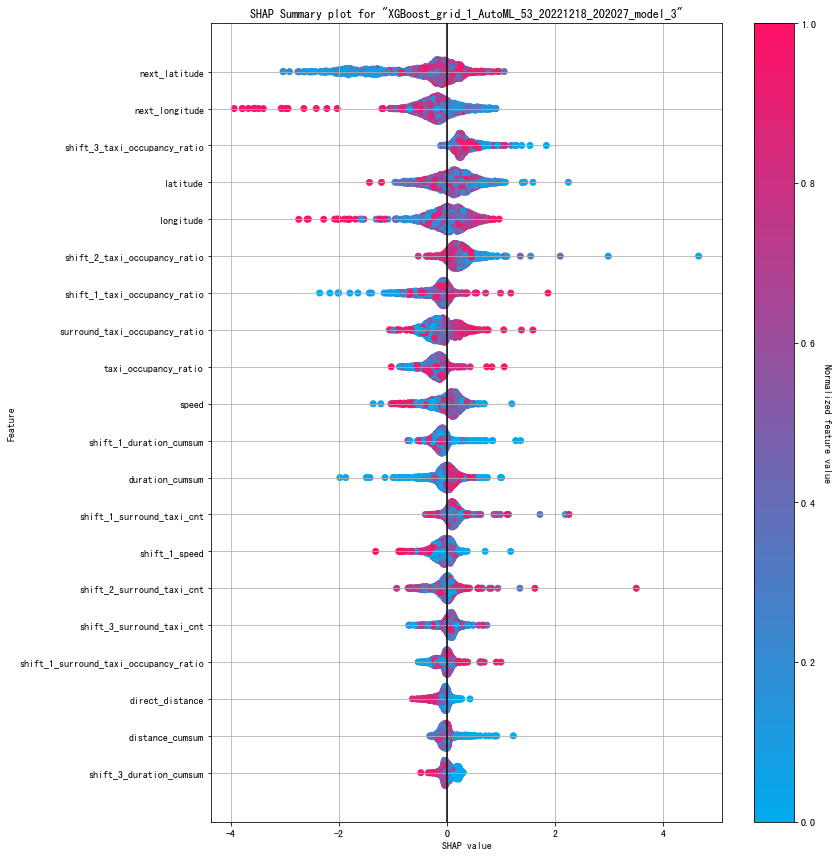

In [434]:
model_cls.shap_summary_plot(valid,  top_n_features = 20)

Based on the above two shap value plots, we can understand
1) Taxi occupancuy rate in the aero surrounding the taxi is important for the taxi to be occupied. This higher ratio means higer deamnd of taxi usage
2) The more northeast, the higher chance to get a passenger in next destination. This might because the downtown is in the northeast of San Francisco
3) Speed is also a factor. If speed is too high, means the road is not crowed and hence less passengers. Also, if speed is high, it will be difficult for driver and passenger to see/find each other.

If the next destination feature is not on top of the important feature list, I will try to exclude the "current position" (which is close to "next position") related features to see if the "next destination" features can be promoted. 

At the beginning with smaller sampled data size, it is better to exclude the "current position" related features due to reason mentioned about. However, long with increasing sampled data size, it is found out both model performance can be improved and "next position" feature can be important (top 2). So the following part are commented out.

In [435]:
# for col in ["latitude","longitude"]:
#     x.remove(col)

# aml = H2OAutoML(max_models=30, seed=1, include_algos=["GBM"],sort_metric="AUCPR",nfolds=3)
# aml.train(x=x, y=y, training_frame=train)

In [436]:
## from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

# model_cls = aml.get_best_model()
# pred_cls=model_cls.predict(valid)
# pred_cls=pred_cls.as_data_frame()

# extend_valid_df=valid.as_data_frame()
# extend_valid_df["predict"]=pred_cls["predict"].values

# print(classification_report(extend_valid_df[y],extend_valid_df["predict"]))
# print("confusion matrix:")
# confusion_matrix(extend_valid_df[y],extend_valid_df["predict"])

In [ ]:
## Check model performance again. 


# from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

# model_cls = aml.get_best_model()
# pred_cls=model_cls.predict(valid)
# pred_cls=pred_cls.as_data_frame()

# extend_valid_df=valid.as_data_frame()
# extend_valid_df["predict"]=pred_cls["predict"].values

# print(classification_report(extend_valid_df[y],extend_valid_df["predict"]))
# print("confusion matrix:")
# confusion_matrix(extend_valid_df[y],extend_valid_df["predict"])

In [437]:
# model_cls.shap_summary_plot(valid,  top_n_features = 20)

### Next destination recommendation and model verification

I will do a simple simulation based on the obtained model, to show how a recommendation engine can be built. Also by comparing with groud truth data, I will show the effectiveness of the recommendation system.

To save time and make the demonstration easy, I will work on the valid data sets which are "pick-up" cases at the next destination

Select out the cases correctly predicted by our model and the predicion is a "pick up"

In [438]:
sub_valid_df=extend_valid_df.loc[(extend_valid_df[y]==1)].reset_index()

In [439]:
len(set(sub_valid_df.session_id))

11063

Get some threshold values for later usage, to ensure our simulated cases are making real sense.

In [440]:
max_speed=np.percentile(sampled_truncated_df.loc[sampled_truncated_df["state_change"]!=-1]["speed"],95)

In [441]:
max_distance=np.percentile(sampled_truncated_df.loc[sampled_truncated_df["state_change"]!=-1]["distance"],95)

In [442]:
## randomly select correctly predicted and wrongly predicted cases as examples
sessions=list(sub_valid_df.loc[sub_valid_df["predict"]==1].session_id.unique())[0:20]+list(sub_valid_df.loc[sub_valid_df["predict"]==0].session_id.unique())[0:20]

In [443]:
max_latitude_change=np.percentile(abs(df["latitude_change"]),95)
max_longitude_change=np.percentile(abs(df["longitude_change"]),95)

In [444]:

output_df=pd.DataFrame()

for session in sessions:

    sub_session_df=sub_valid_df.loc[sub_valid_df["session_id"]==session].reset_index()

    # actual pickup places
    sub_session_df["pick_up_latitude"]=sub_session_df["next_latitude"]
    sub_session_df["pick_up_longitude"]=sub_session_df["next_longitude"]

    # For simplicity, here I do not simulate on time and just use the fixed next time stamp (time point to reach next destination) available in data. 
    # For a workable recommandation system, next timestamp can be also simulated 
    timestamp,next_timestamp=sub_session_df.loc[0,["timestamp","next_timestamp"]]

    simulation_duration=next_timestamp-timestamp

    # "next_latitude" or "pick_up_latitude" are not avaivable in actual predict->recommendation application. Here I take them as reference to contrain the simulation space just for the latter better visualization.
    max_latitude_change_tmp=max(max_latitude_change,abs(sub_session_df.loc[0,"next_latitude"]-sub_session_df.loc[0,"latitude"]))*1.1
    max_longitude_change_tmp=max(max_longitude_change,abs(sub_session_df.loc[0,"next_longitude"]-sub_session_df.loc[0,"longitude"]))*1.1

    max_latitude=sub_session_df.loc[0,"latitude"]+max_latitude_change_tmp
    min_latitude=sub_session_df.loc[0,"latitude"]-max_latitude_change_tmp
    max_longitude=sub_session_df.loc[0,"longitude"]+max_longitude_change_tmp
    min_longitude=sub_session_df.loc[0,"longitude"]-max_longitude_change_tmp

    map_df=df.loc[(df["latitude"]<=max_latitude) & (df["latitude"]>=min_latitude) & (df["longitude"]<=max_longitude) & (df["longitude"]>=min_longitude)][["latitude","longitude"]].drop_duplicates().reset_index(drop=True)

    if map_df.shape[0]>20000:
        simulation_df=map_df.sample(n=20000,random_state=1)
    else:
        simulation_df=map_df

    simulation_df.columns=["next_latitude","next_longitude"]

    # attach other feature columns. They are not simulated and they keep the original values
    for col in sub_session_df.columns:
        if col not in ["next_latitude","next_longitude","next_latitude_change","next_longitude_change"]:
            simulation_df[col]=sub_session_df.loc[0,col]

    # rewrite derived features which depend on "next_latitude","next_longitude"
    simulation_df["next_latitude_change"]=np.sign(simulation_df["next_latitude"]-simulation_df["latitude"])
    simulation_df["next_longitude_change"]=np.sign(simulation_df["next_longitude"]-simulation_df["longitude"])


    simulation_df["simulation_distance"]=simulation_df.apply(lambda row:distance(row["next_latitude"],row["latitude"],row["next_longitude"],row["longitude"]),axis=1)

    simulation_df["simulation_speed"]=simulation_df["simulation_distance"]/simulation_duration

    # remove unrealistic cases from simulation space based on consideration of speed and moving distance in a given duration 
    simulation_df=simulation_df.loc[(simulation_df["simulation_speed"]<=max_speed*1.3) & (simulation_df["simulation_distance"]<=max_distance*1.3)]

    if simulation_df.shape[0]>0:

        # apply our model and make predictions
        pred_on_simulation=model_cls.predict(h2o.H2OFrame(simulation_df)).as_data_frame()

        simulation_df["local_p1"]=pred_on_simulation["p1"].values

        simulation_df["local_predict"]=pred_on_simulation["predict"].values

        sub_output_df=simulation_df[["session_id","taxi","timestamp","next_timestamp","next_latitude","next_longitude","latitude","longitude","pick_up_latitude","pick_up_longitude","predict","local_p1","local_predict"]].reset_index(drop=True)

        output_df=output_df.append(sub_output_df)

output_df=output_df.reset_index(drop=True)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████████████

Check the threshold value of probability for 0/1 classification by the model

In [445]:
output_df.loc[output_df["local_predict"]==1]["local_p1"].min()

0.2274865955114364

In [446]:
output_df.loc[output_df["local_predict"]==0]["local_p1"].max()

0.2274537533521652

In [447]:
output_df["threshold"]=output_df.loc[output_df["local_predict"]==0]["local_p1"].max()

taxi              new_abboip
timestamp         1211472523
next_timestamp    1211472529
predict                    1
threshold           0.227454
Name: 0, dtype: object


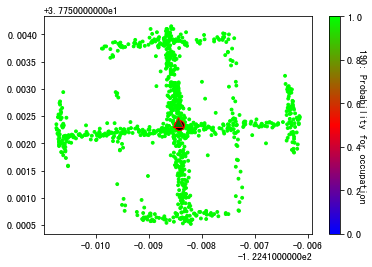

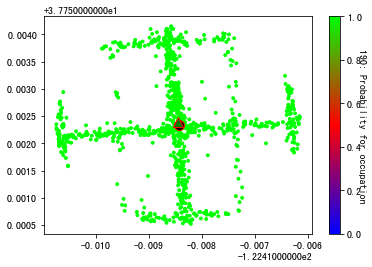

***********
taxi              new_abboip
timestamp         1211756439
next_timestamp    1211756493
predict                    1
threshold           0.227454
Name: 0, dtype: object


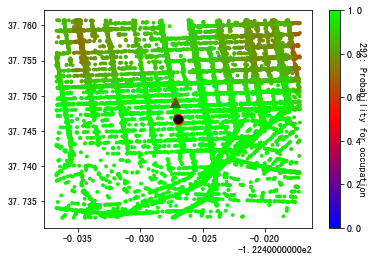

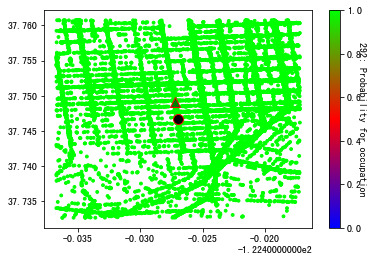

***********
taxi              new_abboip
timestamp         1211758411
next_timestamp    1211758464
predict                    1
threshold           0.227454
Name: 0, dtype: object


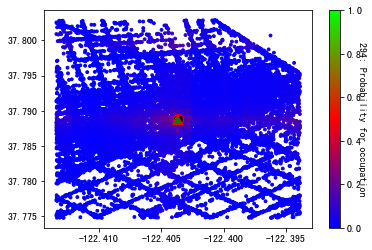

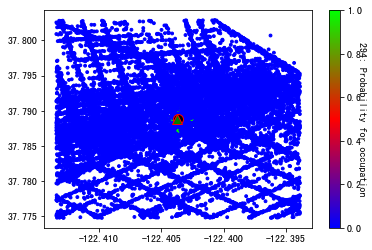

***********
taxi              new_abboip
timestamp         1212099866
next_timestamp    1212099913
predict                    1
threshold           0.227454
Name: 0, dtype: object


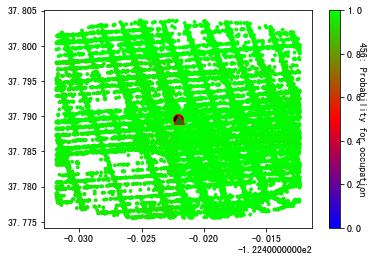

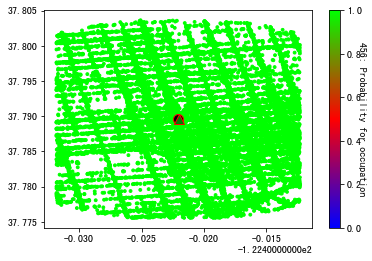

***********
taxi              new_abboip
timestamp         1212104273
next_timestamp    1212104310
predict                    1
threshold           0.227454
Name: 0, dtype: object


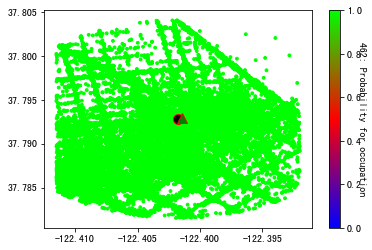

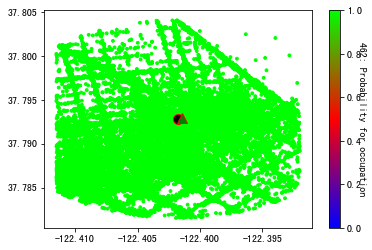

***********
taxi              new_abboip
timestamp         1212297045
next_timestamp    1212297065
predict                    1
threshold           0.227454
Name: 0, dtype: object


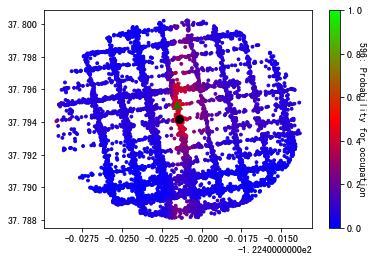

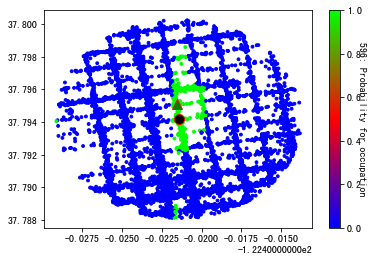

***********
taxi              new_abboip
timestamp         1212818175
next_timestamp    1212818177
predict                    1
threshold           0.227454
Name: 0, dtype: object


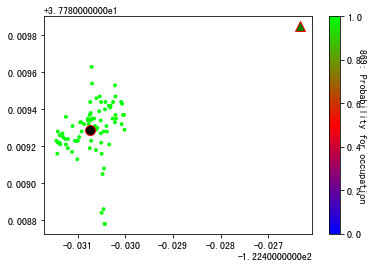

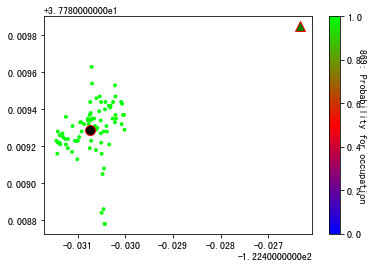

***********
taxi              new_abdremlu
timestamp           1212465203
next_timestamp      1212466377
predict                      1
threshold             0.227454
Name: 0, dtype: object


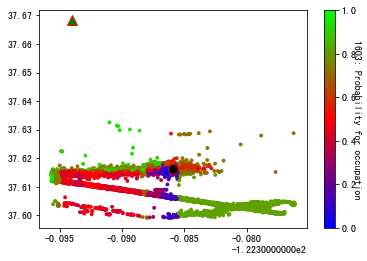

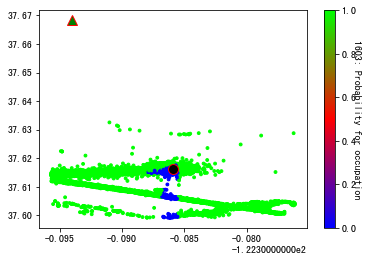

***********
taxi              new_abdremlu
timestamp           1212896894
next_timestamp      1212896912
predict                      1
threshold             0.227454
Name: 0, dtype: object


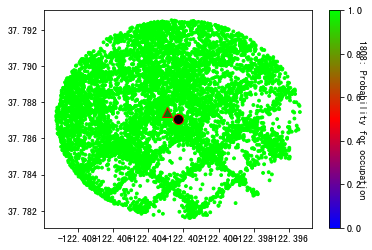

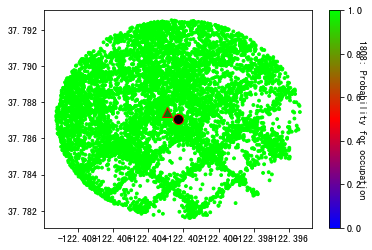

***********
taxi              new_abgibo
timestamp         1212296892
next_timestamp    1212296947
predict                    1
threshold           0.227454
Name: 0, dtype: object


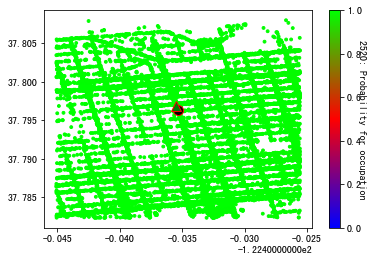

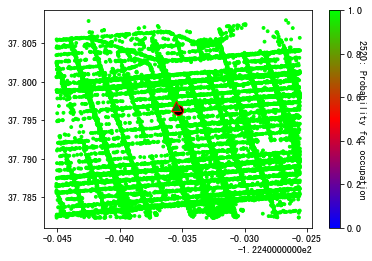

***********
taxi              new_abgibo
timestamp         1212467140
next_timestamp    1212467152
predict                    1
threshold           0.227454
Name: 0, dtype: object


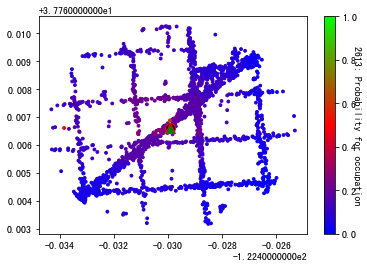

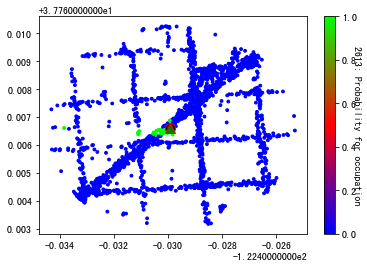

***********
taxi              new_abjoolaw
timestamp           1211255229
next_timestamp      1211255251
predict                      1
threshold             0.227454
Name: 0, dtype: object


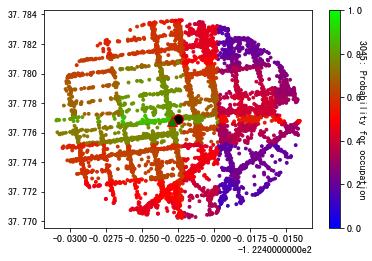

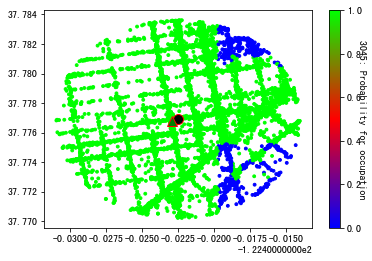

***********
taxi              new_abjoolaw
timestamp           1212799601
next_timestamp      1212799629
predict                      1
threshold             0.227454
Name: 0, dtype: object


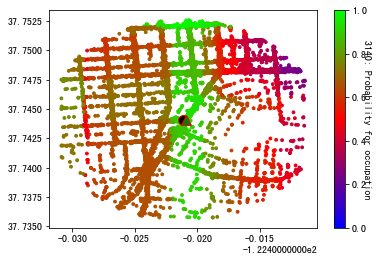

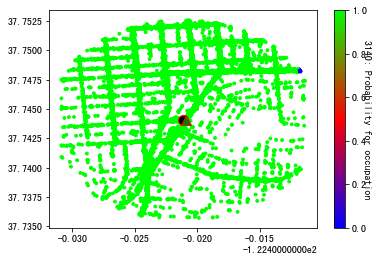

***********
taxi              new_abjoolaw
timestamp           1212802795
next_timestamp      1212802849
predict                      1
threshold             0.227454
Name: 0, dtype: object


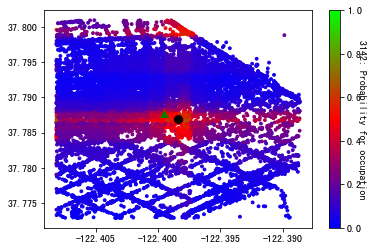

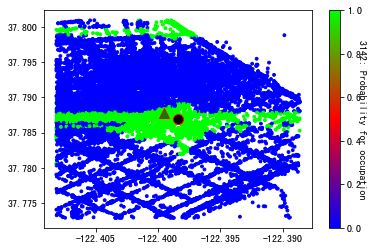

***********
taxi              new_abjoolaw
timestamp           1212899306
next_timestamp      1212899343
predict                      1
threshold             0.227454
Name: 0, dtype: object


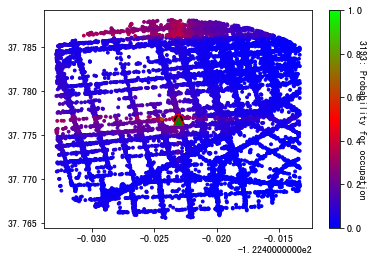

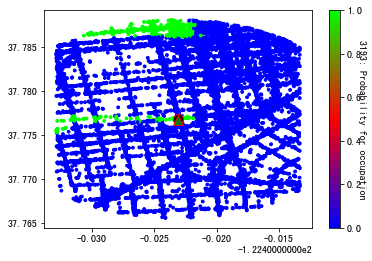

***********
taxi              new_abmuyawm
timestamp           1211121685
next_timestamp      1211121687
predict                      1
threshold             0.227454
Name: 0, dtype: object


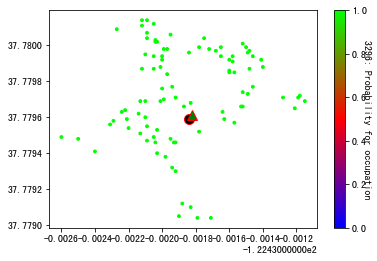

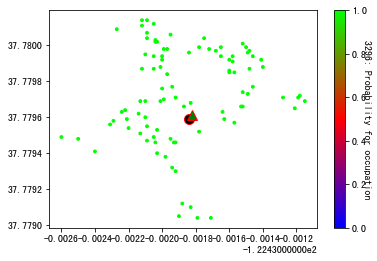

***********
taxi              new_abmuyawm
timestamp           1211560789
next_timestamp      1211560820
predict                      1
threshold             0.227454
Name: 0, dtype: object


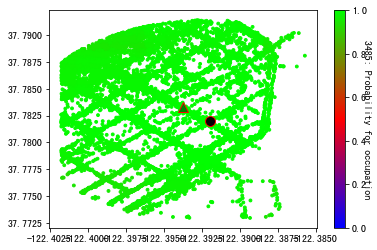

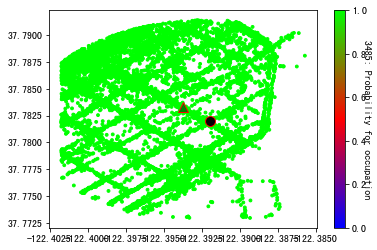

***********
taxi              new_abmuyawm
timestamp           1212770035
next_timestamp      1212770086
predict                      1
threshold             0.227454
Name: 0, dtype: object


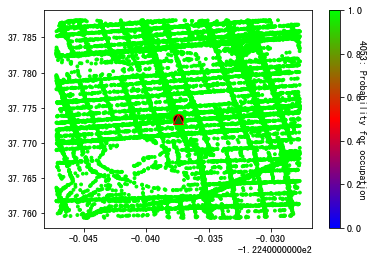

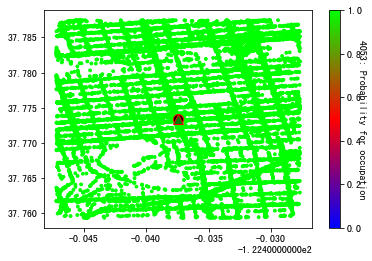

***********
taxi              new_abmuyawm
timestamp           1212903695
next_timestamp      1212903740
predict                      1
threshold             0.227454
Name: 0, dtype: object


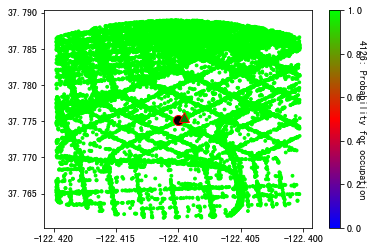

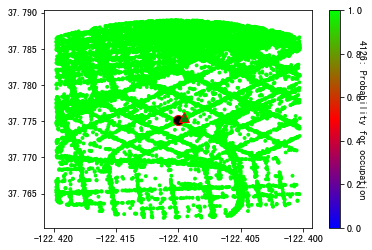

***********
taxi              new_abmuyawm
timestamp           1212981895
next_timestamp      1212981918
predict                      1
threshold             0.227454
Name: 0, dtype: object


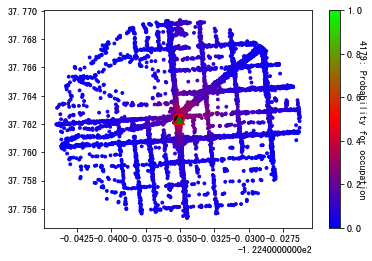

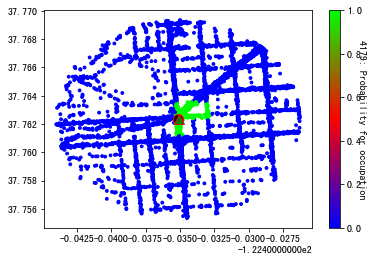

***********
taxi              new_abboip
timestamp         1211680325
next_timestamp    1211680403
predict                    0
threshold           0.227454
Name: 0, dtype: object


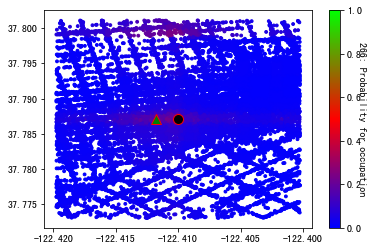

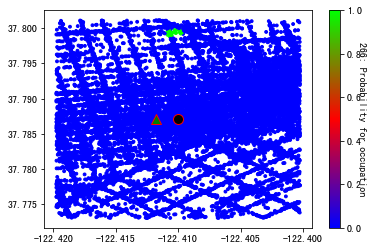

***********
taxi              new_abboip
timestamp         1212025301
next_timestamp    1212025328
predict                    0
threshold           0.227454
Name: 0, dtype: object


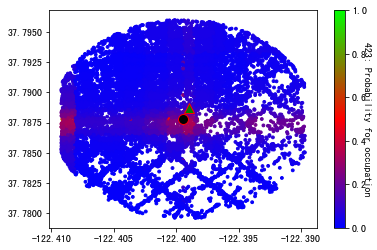

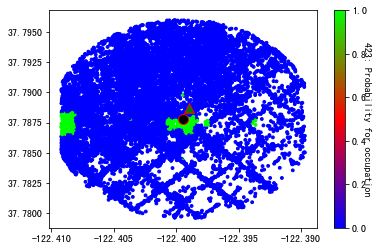

***********
taxi              new_abboip
timestamp         1212103781
next_timestamp    1212103810
predict                    0
threshold           0.227454
Name: 0, dtype: object


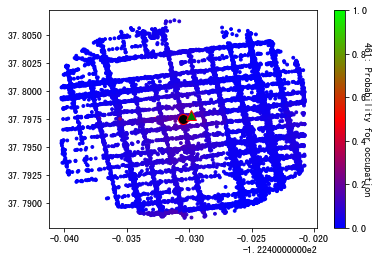

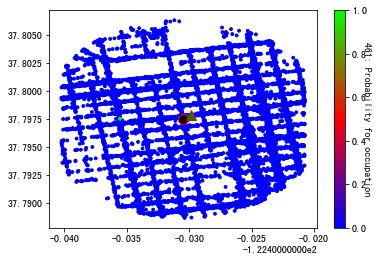

***********
taxi              new_abdremlu
timestamp           1211148663
next_timestamp      1211148715
predict                      0
threshold             0.227454
Name: 0, dtype: object


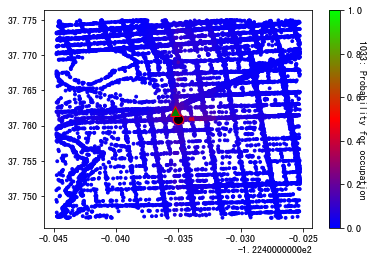

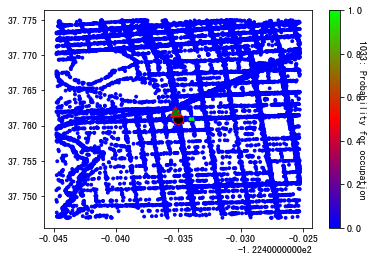

***********
taxi              new_abdremlu
timestamp           1212675027
next_timestamp      1212675087
predict                      0
threshold             0.227454
Name: 0, dtype: object


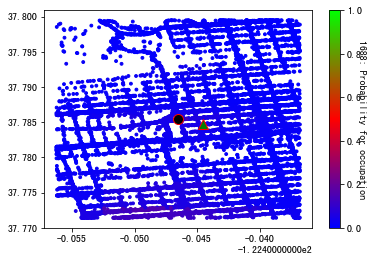

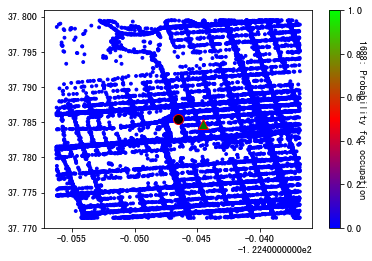

***********
taxi              new_abdremlu
timestamp           1212974885
next_timestamp      1212974986
predict                      0
threshold             0.227454
Name: 0, dtype: object


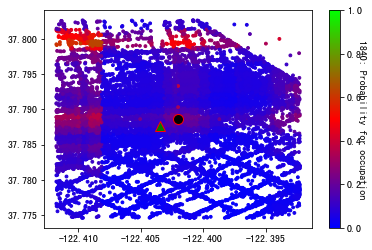

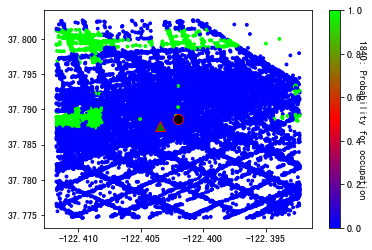

***********
taxi              new_abgibo
timestamp         1211507126
next_timestamp    1211507172
predict                    0
threshold           0.227454
Name: 0, dtype: object


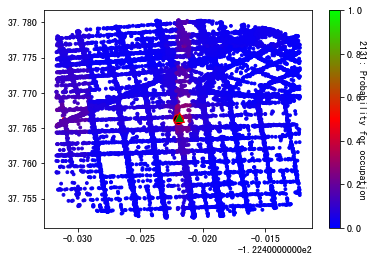

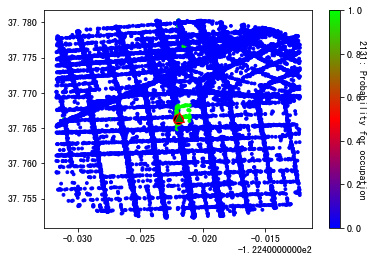

***********
taxi              new_abgibo
timestamp         1211515386
next_timestamp    1211515425
predict                    0
threshold           0.227454
Name: 0, dtype: object


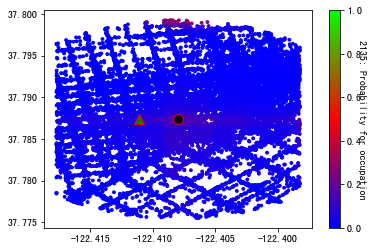

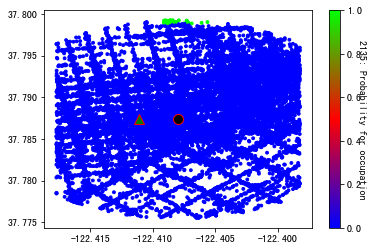

***********
taxi              new_abgibo
timestamp         1211686257
next_timestamp    1211686259
predict                    0
threshold           0.227454
Name: 0, dtype: object


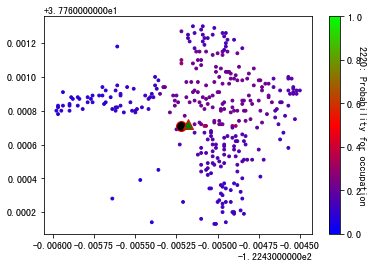

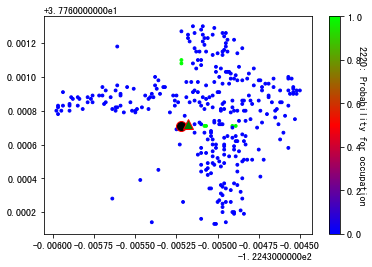

***********
taxi              new_abgibo
timestamp         1212012766
next_timestamp    1212012774
predict                    0
threshold           0.227454
Name: 0, dtype: object


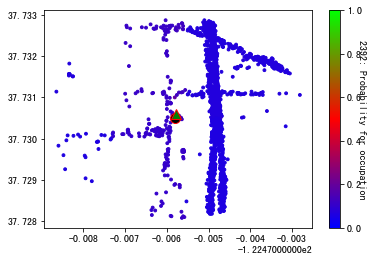

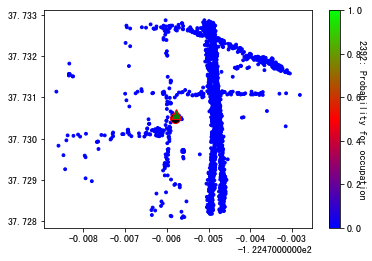

***********
taxi              new_abgibo
timestamp         1212344702
next_timestamp    1212344757
predict                    0
threshold           0.227454
Name: 0, dtype: object


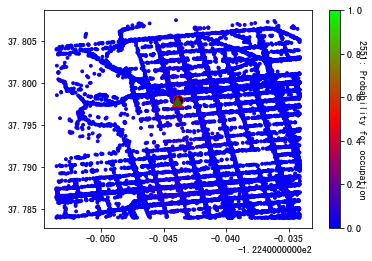

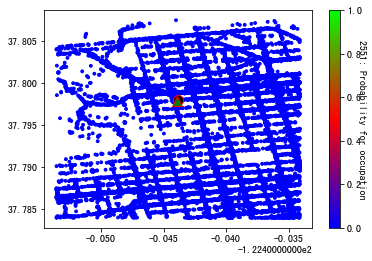

***********
taxi              new_abgibo
timestamp         1212401666
next_timestamp    1212401700
predict                    0
threshold           0.227454
Name: 0, dtype: object


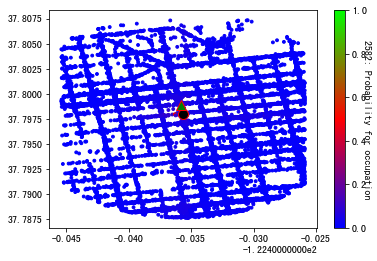

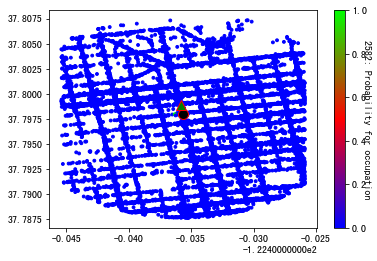

***********
taxi              new_abmuyawm
timestamp           1211499726
next_timestamp      1211499757
predict                      0
threshold             0.227454
Name: 0, dtype: object


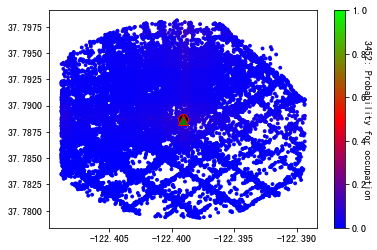

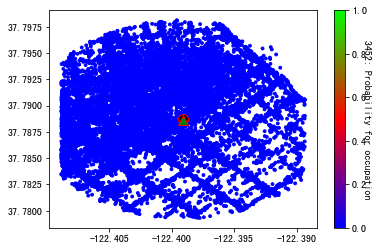

***********
taxi              new_abmuyawm
timestamp           1212110599
next_timestamp      1212110641
predict                      0
threshold             0.227454
Name: 0, dtype: object


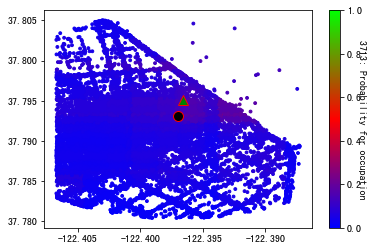

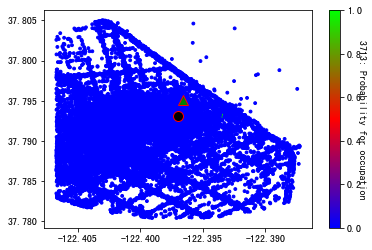

***********
taxi              new_abniar
timestamp         1212334657
next_timestamp    1212334666
predict                    0
threshold           0.227454
Name: 0, dtype: object


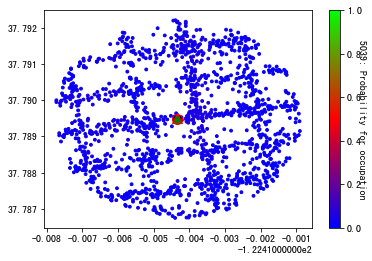

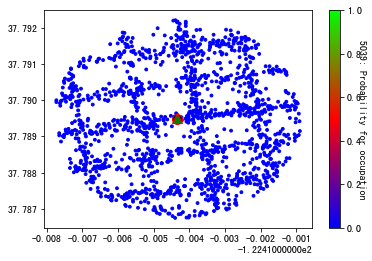

***********
taxi              new_abniar
timestamp         1212686658
next_timestamp    1212686665
predict                    0
threshold           0.227454
Name: 0, dtype: object


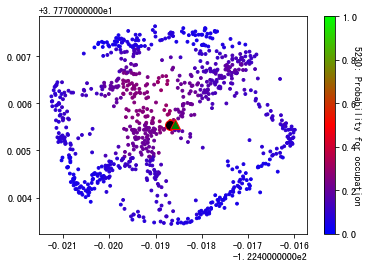

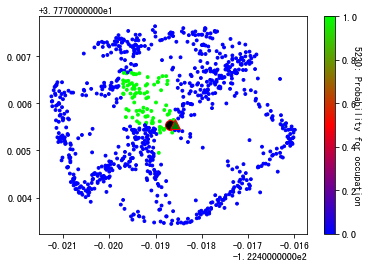

***********
taxi              new_abniar
timestamp         1212851214
next_timestamp    1212851274
predict                    0
threshold           0.227454
Name: 0, dtype: object


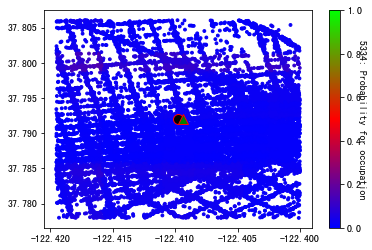

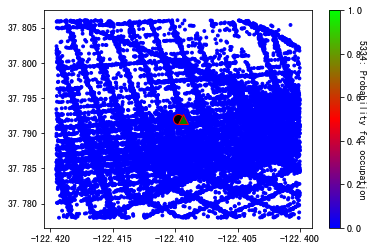

***********
taxi              new_abnovkak
timestamp           1211812260
next_timestamp      1211812263
predict                      0
threshold             0.227454
Name: 0, dtype: object


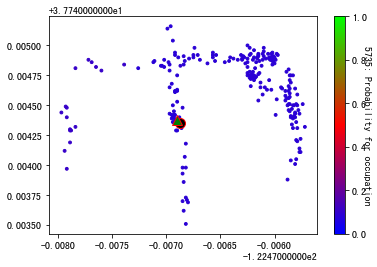

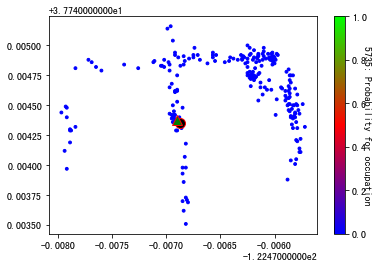

***********
taxi              new_abtyff
timestamp         1212785953
next_timestamp    1212785992
predict                    0
threshold           0.227454
Name: 0, dtype: object


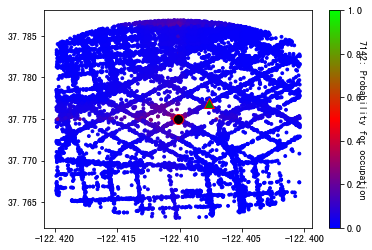

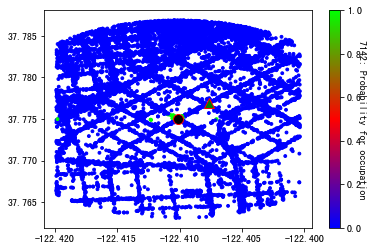

***********
taxi              new_abwecnij
timestamp           1211499676
next_timestamp      1211499677
predict                      0
threshold             0.227454
Name: 0, dtype: object


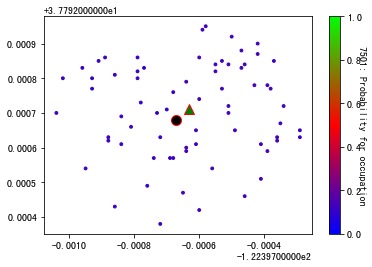

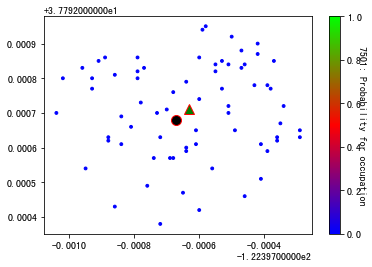

***********


In [448]:
import matplotlib

colormap = plt.cm.brg #or any other colormap
normalize = matplotlib.colors.Normalize(vmin=0, vmax=1)


for session in sessions:
    
    tmp=output_df.loc[output_df["session_id"]==session].reset_index()

    print(tmp.loc[0,["taxi","timestamp","next_timestamp","predict","threshold"]])

    ## probability visualization
    plt.scatter(tmp["next_longitude"], tmp["next_latitude"],  c=tmp["local_p1"], s=8,cmap=colormap, alpha=1)

    plt.plot(tmp.loc[0,"longitude"], tmp.loc[0,"latitude"], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="black")

    plt.plot(tmp.loc[0,"pick_up_longitude"], tmp.loc[0,"pick_up_latitude"], marker="^", markersize=10, markeredgecolor="red", markerfacecolor="green")

    plt.colorbar().ax.set_ylabel(f"{session}: Probability for occupation",fontsize=10,rotation=270)
    plt.clim(0,1)

    plt.show()

    ## binary visualization

    plt.scatter(tmp["next_longitude"], tmp["next_latitude"],  c=tmp["local_predict"], s=8, cmap=colormap, alpha=1)

    plt.plot(tmp.loc[0,"longitude"], tmp.loc[0,"latitude"], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="black")

    plt.plot(tmp.loc[0,"pick_up_longitude"], tmp.loc[0,"pick_up_latitude"], marker="^", markersize=10, markeredgecolor="red", markerfacecolor="green")

    plt.colorbar().ax.set_ylabel(f"{session}: Probability for occupation",fontsize=10,rotation=270)
    plt.clim(0,1)

    plt.show()

    print("***********")
